In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
#read data
stk_a_df = pd.read_csv(r'E:\study\22fall\hf\data\hw1\ALB.csv')[["Date",'Adj Close']].dropna(axis=0).set_index('Date')
stk_a_df.index = pd.to_datetime(stk_a_df.index)
stk_b_df = pd.read_csv(r'E:\study\22fall\hf\data\hw1\XOM.csv')[['Date','Adj Close']].dropna(axis=0).set_index('Date')
stk_b_df.index = pd.to_datetime(stk_b_df.index)
bmk_df = pd.read_csv(r'E:\study\22fall\hf\data\hw1\sp500.csv')[['Date','Adj Close']].dropna(axis=0).set_index('Date')
bmk_df.index = pd.to_datetime(bmk_df.index)
bmk_df.loc[:,'Adj Close'] = np.float64(bmk_df.loc[:,'Adj Close'])
stk_a_df = stk_a_df.reindex(bmk_df.index)
stk_b_df = stk_b_df.reindex(bmk_df.index)
#return
ror_a_df = stk_a_df/stk_a_df.shift(1)-1
ror_b_df = stk_b_df/stk_b_df.shift(1)-1
ror_bmk_df = bmk_df/bmk_df.shift(1)-1
ror_df = pd.concat([ror_a_df,ror_b_df,ror_bmk_df],axis=1)
ror_10_treasure_float = 0.03319

Chose XOM and ALB to construct portfolio with equal weights.

XOM is a leading oil and natural gas producer. Due to Ukraine crisis and high inflation,
the world is suffering a energy crisis, especially Europe. Since both the war and inflation is far from ending,
I think energy resources, both oil and natural gas , will not return to its normal level very soon, which is a guarantee
 to XOM's earning at least in the near future.

ALB is a Lithium producer with high growth in earning in 2022. Lithium is not only an indispensable material in producing
 battery in the current booming electric vehicle industry but also key to building energy storage construction which would be popular
 both to profit through electricity trade and balance price of electricity. Therefore, though Lithium's price is very high right now,
 I think it will not drop sharply recently.

Considering that their PEG is far below 1,around 0.3,0.4 separately, I think both of them are very promising.

In [2]:
#allocation
def allocate(cash_float:float,weights_array:np.array,price_array:np.array)->tuple: #commission: 0.005/share
    cash_weighted_array = cash_float*weights_array
    share_array = np.floor(cash_weighted_array/(price_array+0.005))
    price_sum_float = np.sum(share_array*price_array+0.005*share_array)
    cash_float -= price_sum_float
    return cash_float,share_array

def sharp(ror_d_array):
    ror_y_float = np.exp(np.log(1+ror_d_array).sum() / (ror_d_array.shape[1]/252))-1
    std_y_float = np.std(ror_d_array)*np.sqrt(252)
    return (ror_y_float-0.03319)/std_y_float

In [3]:
# parameters
end_str = '2022-09-09'
end_loc_int = np.where(stk_a_df.index==end_str)[0][0]

In [4]:
#backtest last X trade days
period_int = 20
beg_loc_int = end_loc_int-period_int
cash_init_float = 1000000.0
price_array = np.array([stk_a_df.iloc[beg_loc_int,0],stk_b_df.iloc[beg_loc_int,0]])
weights_array = np.array([0.5,0.5])

I chose to buy as many stocks as possible with given cash and arrange them with equal weight in the portfolio. Equal
weights is not only easy but also has no implicit effects on the portfolio like market capitalisation weighted method which
 naturally possesses momentum. market capitalisation weighted method would make the portfolio performs much more like XOM,
 whose capitalisation is far bigger than ALB.

Mean varaince optimization(mvo) is ideal if data is sufficient, but right now my data source is very limited and a robust
  MVO is relatively complicated so I did not employ this method. Also, I don't think MVO would make much difference in a
   portfolio made up by only 2 stocks compared with equal weights.

In [5]:
cash_float,share_array = allocate(cash_init_float,weights_array,price_array)
#cal portfolio mkt val
ror_array = ror_df.iloc[beg_loc_int+1:end_loc_int+1,:].values
accu_ret_array = np.multiply.accumulate(ror_array+1,axis=0)
stk_mkt_val_array = share_array*price_array.reshape(1,2)
mkt_val_array = stk_mkt_val_array*accu_ret_array[:,:2]
mkt_val_array = np.concatenate((stk_mkt_val_array,mkt_val_array),axis=0)
portfolio_daily_ret_array = np.diff(mkt_val_array,1,axis=0)
portfolio_daily_ret_cmb_array = portfolio_daily_ret_array.sum(axis=1).reshape(-1,1)
partial_sum_portfolio_ret_array = np.add.accumulate(portfolio_daily_ret_array,0)
portfolio_mv_array = np.sum(mkt_val_array,axis=1)+cash_float

#bmk ret
bmk_ret_array = cash_init_float*accu_ret_array[:,2]
bmk_ret_array = np.concatenate((np.array(cash_init_float).reshape(1,1),bmk_ret_array.reshape(-1,1)))
bmk_daily_ret_array = np.diff(bmk_ret_array,1,axis=0)
partial_sum_bmk_ret_array = np.add.accumulate(bmk_daily_ret_array,0)

#gen dataset
daily_ret_array = np.concatenate((portfolio_daily_ret_cmb_array,bmk_daily_ret_array),axis=1)

In [6]:
#metric ouput
porfolio_ror_array = np.matmul(weights_array.reshape(1,2),ror_array[:,:2].T)
portfolio_sharp_float = sharp(porfolio_ror_array)
bmk_sharp_float = sharp(ror_array[:,-1].reshape(1,-1))
corrs_float = np.corrcoef(daily_ret_array.T)
print(f'corr: {corrs_float[0][1]}')
print(f'sharp:\n\tportfolio: {portfolio_sharp_float},\n\tbenchmark(SP500): {bmk_sharp_float}')

corr: 0.5357607545325154
sharp:
	portfolio: 5.419729520093665,
	benchmark(SP500): -1.8180189063881658


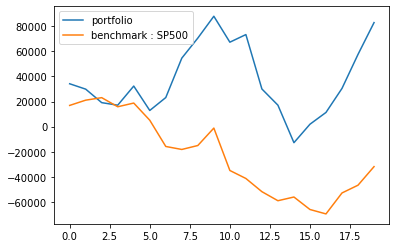

In [7]:
#plotting
plt.plot(np.sum(partial_sum_portfolio_ret_array,axis=1),label='portfolio')
plt.plot(partial_sum_bmk_ret_array,label='benchmark : SP500')
plt.legend()
plt.show()

In the backtest, the portfolio outperforms market, which is not surprising since I constructed the portfolio basing on historical data.

The apparent drawback is that the portfolio's resistance to sudden fall like that on the right side of the graph is low and can be even more risky
than benchmark, which is a very difficult problem to solve.

Also, metric like sharp ratio is not very useful in such a short period of backtest since annualized average return can be extremely high
 which lead to high sharp ratio.